In [ ]:
# Necessary imports
import findspark
findspark.init() # Find Spark installation

from pyspark.sql import functions as F
from pyspark.sql.types import *

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *

import matplotlib.pyplot as plt

import pandas as pd

In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [3]:
from pyspark.sql.functions import hour, dayofweek, month, year, when

# Extract time-based features from Start_Time
df = df.withColumn("hour_of_day", hour(df["Start_Time"]))
df = df.withColumn("day_of_week", dayofweek(df["Start_Time"]))
df = df.withColumn("month", month(df["Start_Time"]))
df = df.withColumn("year", year(df["Start_Time"]))

# Handle categorical features - Weather_Condition
df = df.withColumn("weather_condition_cat", when(df["Weather_Condition"] == "Clear", 0)
                                            .when(df["Weather_Condition"] == "Rain", 1)
                                            .when(df["Weather_Condition"] == "Snow", 2)
                                            .otherwise(3))

# Add a binary feature for day/night based on the time of the accident
df = df.withColumn("is_night", when((df["hour_of_day"] >= 18) | (df["hour_of_day"] < 6), 1).otherwise(0))

# Create a boolean flag for severe accidents (Severity >= 3)
df = df.withColumn("severe_accident", when(df["Severity"] >= 3, 1).otherwise(0))

df.show(5)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+-----+----+---------------------+--------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visib

In [4]:
# Fill missing values in columns like temperature, wind speed with the mean or median
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

# Drop rows with missing target variables (if any)
df = df.dropna(subset=["Severity"])


In [5]:
# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [6]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assemble features into a single vector column
feature_cols = ["hour_of_day", "day_of_week", "month", "Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed", "is_night", "weather_condition_cat"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Train a Random Forest model
rf = RandomForestClassifier(labelCol="severe_accident", featuresCol="features", numTrees=100)
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.2f}")


Model Accuracy: 0.81


In [11]:
# Get feature importances from the trained model
feature_importances = model.featureImportances

# Convert feature importances to a Pandas DataFrame for easy viewing
feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": feature_importances.toArray()  # Convert SparseVector to dense array
}).sort_values(by="importance", ascending=False)

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                 feature  importance
7  weather_condition_cat    0.595962
4     Wind_Speed_imputed    0.215379
1            day_of_week    0.076574
2                  month    0.058833
0            hour_of_day    0.022498
6               is_night    0.016043
5       Humidity_imputed    0.010184
3    Temperature_imputed    0.004527


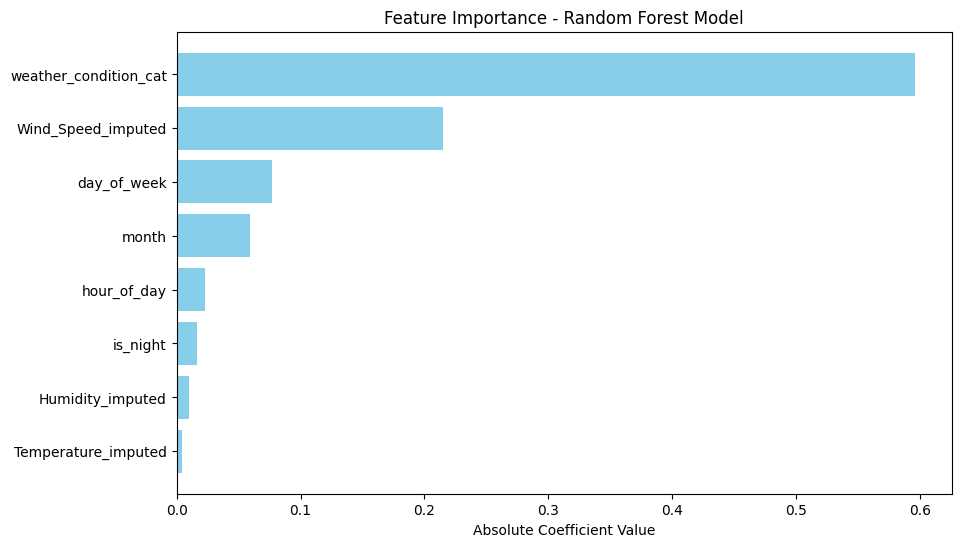

In [16]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance - Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="severe_accident", rawPredictionCol="prediction")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC Score: {roc_auc:.2f}")


ROC-AUC Score: 0.50


In [13]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.80
Recall: 0.81
F1-Score: 0.72


In [14]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Create a geospatial feature by combining latitude and longitude
geo_assembler = VectorAssembler(inputCols=["Start_Lat", "Start_Lng"], outputCol="geo_features")
df = geo_assembler.transform(df)

# KMeans clustering to identify accident hotspots
kmeans = KMeans(k=5, featuresCol="geo_features", predictionCol="cluster")
model = kmeans.fit(df)
df = model.transform(df)

# Show the clustered data
df.select("Start_Lat", "Start_Lng", "cluster").show(5)


+-----------------+------------------+-------+
|        Start_Lat|         Start_Lng|cluster|
+-----------------+------------------+-------+
|        39.865147|        -84.058723|      0|
|39.92805900000001|        -82.831184|      0|
|        39.063148|        -84.032608|      0|
|        39.747753|-84.20558199999998|      0|
|        39.627781|        -84.188354|      0|
+-----------------+------------------+-------+
only showing top 5 rows

